In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [2]:
df = pd.read_json("/Users/naveenmsu/Downloads/archive (11)/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
del df['article_link'] # Deleting this column as it is of no use
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [4]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

/var/folders/pl/xqlcfhp16mx__n265hhwsrl00000gn/T/ipykernel_17476/2066145181.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [5]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [6]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)


In [7]:
#vocab size
len(w2v_model.wv)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [8]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [9]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [10]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [11]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model.wv, tokenizer.word_index)

In [12]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           7614400   
                                                                 
 bidirectional (Bidirection  (None, 20, 256)           336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8007041 (30.54 MB)
Trainable params: 8007041 (30.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [15]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
157/157 [==============================] - 43s 251ms/step - loss: 0.5307 - acc: 0.7163 - val_loss: 0.4314 - val_acc: 0.8028
Epoch 2/3
157/157 [==============================] - 48s 304ms/step - loss: 0.2130 - acc: 0.9136 - val_loss: 0.4477 - val_acc: 0.8061
Epoch 3/3
157/157 [==============================] - 48s 309ms/step - loss: 0.0706 - acc: 0.9749 - val_loss: 0.6484 - val_acc: 0.8026


In [16]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 12s 20ms/step - loss: 0.0228 - acc: 0.9939
Accuracy of the model on Training Data is -  99.39100742340088
269/269 [==============================] - 5s 20ms/step - loss: 0.6484 - acc: 0.8026
Accuracy of the model on Testing Data is -  80.25856018066406


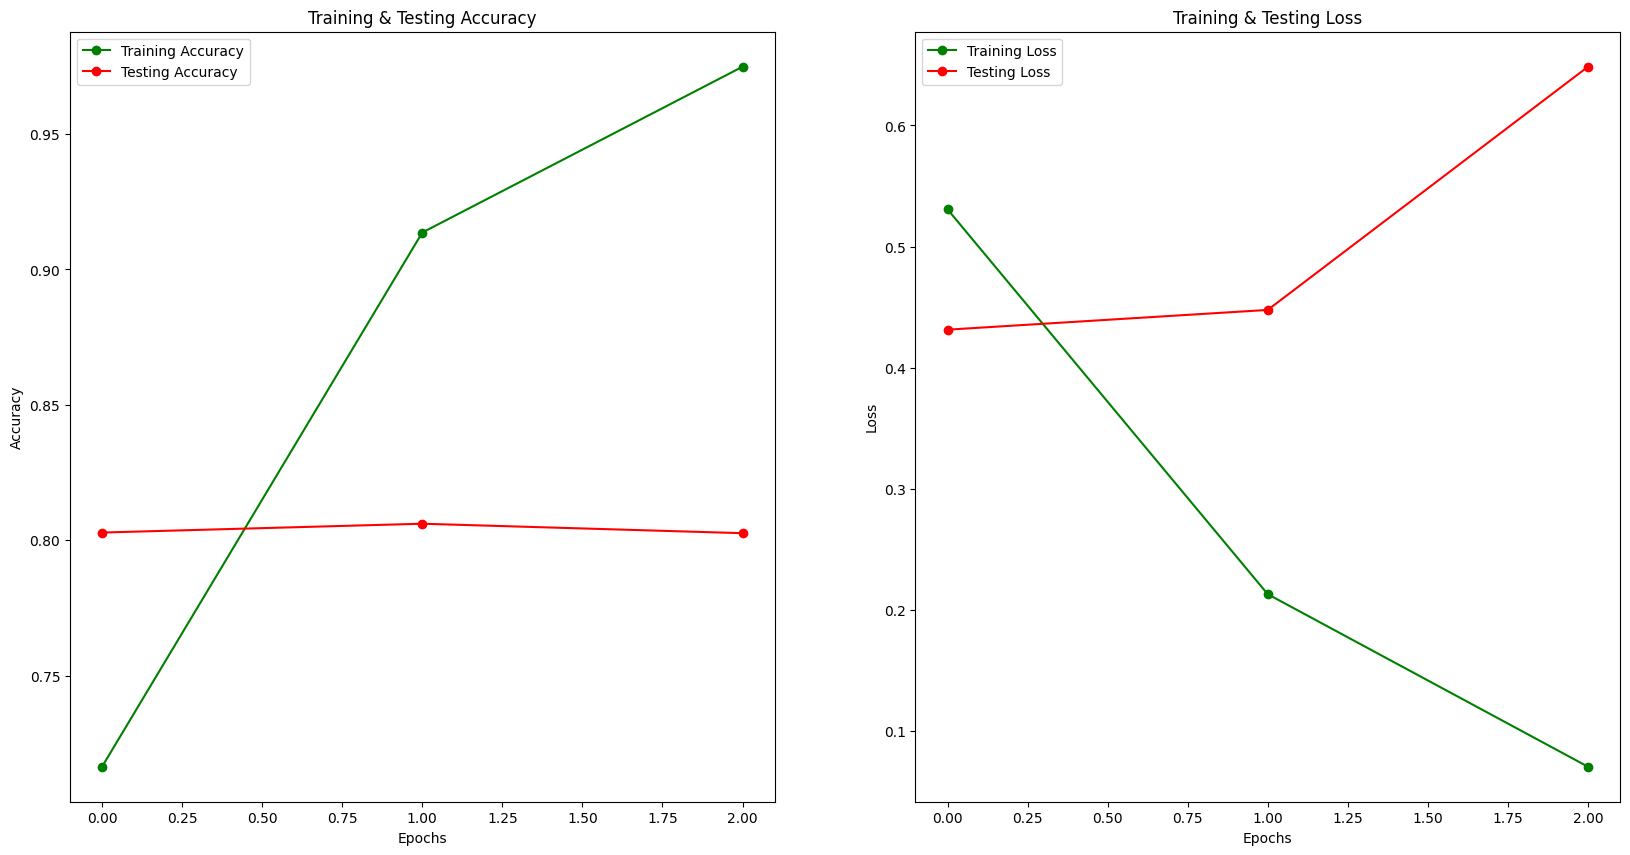

In [17]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [18]:
pred = model.predict(x_test)
for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0
pred[:5]

269/269 [==============================] - 6s 22ms/step


array([[1.],
       [0.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [19]:
cm = confusion_matrix(y_test,pred)
cm

array([[3647,  913],
       [ 782, 3244]])

<Axes: >

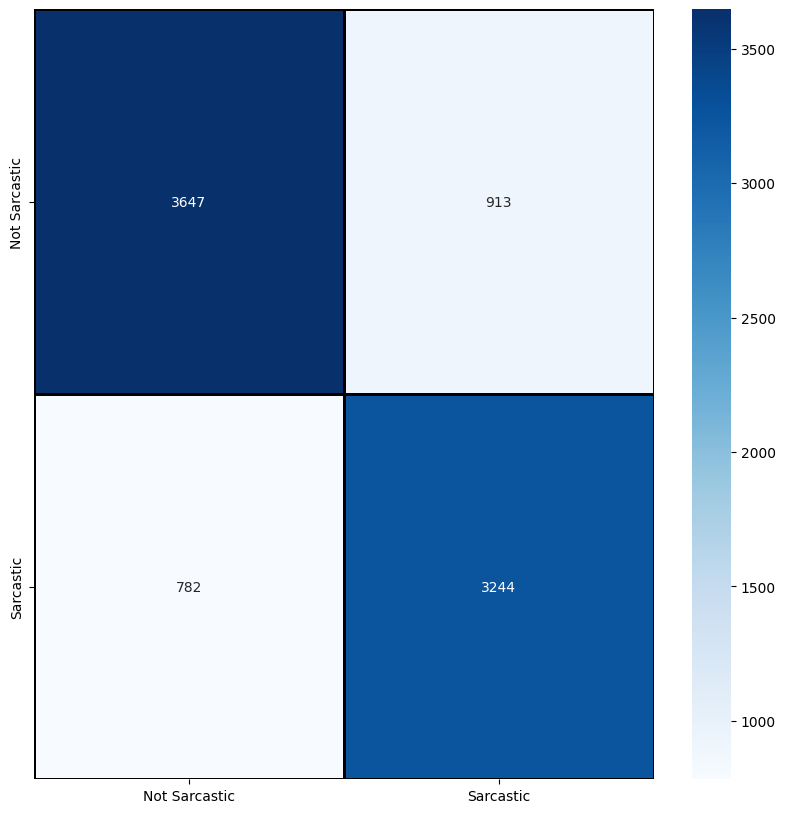

In [20]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [21]:
labels = df.is_sarcastic.values
sentences = df.headline.values
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails congress falling short ...
2,0,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word 'streamin...


In [22]:
from transformers import TFBertModel, BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

In [23]:
#Train test split
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences, labels,test_size=0.15)

train_ids = encoder(train_sents)
test_ids = encoder(test_sents) 

train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

/Users/naveenmsu/miniforge3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [24]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  

In [26]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 16)]              0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 16, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [27]:
history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/3


761/761 [==============================] - 698s 904ms/step - loss: 0.4176 - accuracy: 0.8033 - val_loss: 0.2835 - val_accuracy: 0.8768
Epoch 2/3
761/761 [==============================] - 684s 898ms/step - loss: 0.2548 - accuracy: 0.8951 - val_loss: 0.2639 - val_accuracy: 0.8891
Epoch 3/3
761/761 [==============================] - 686s 901ms/step - loss: 0.1571 - accuracy: 0.9396 - val_loss: 0.2695 - val_accuracy: 0.8987


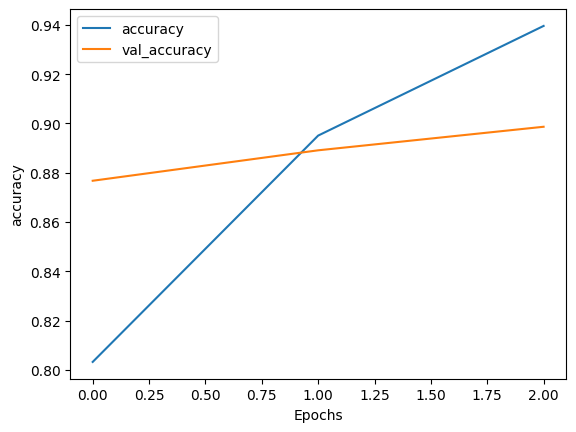

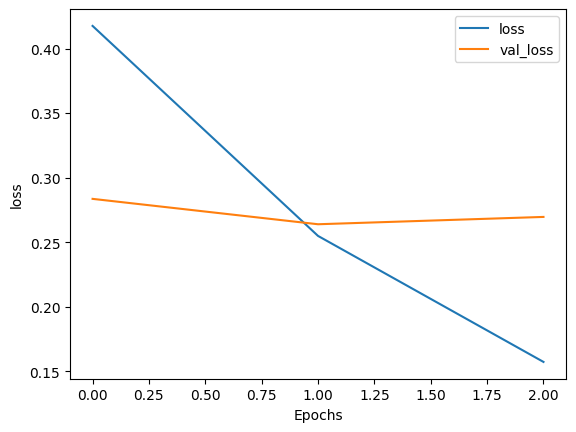

In [28]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [29]:
print("Accuracy of the model on Training Data is - " , model.evaluate(train_ids,train_labels)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(test_ids,test_labels)[1]*100)

761/761 [==============================] - 207s 271ms/step - loss: 0.0498 - accuracy: 0.9887
Accuracy of the model on Training Data is -  98.87363314628601
135/135 [==============================] - 36s 269ms/step - loss: 0.2695 - accuracy: 0.8987
Accuracy of the model on Testing Data is -  89.86722826957703


In [30]:
pred = model.predict(test_ids)
for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0
pred[:5]
cm = confusion_matrix(test_labels,pred)
cm

135/135 [==============================] - 38s 273ms/step


array([[2025,  221],
       [ 214, 1833]])

<Axes: >

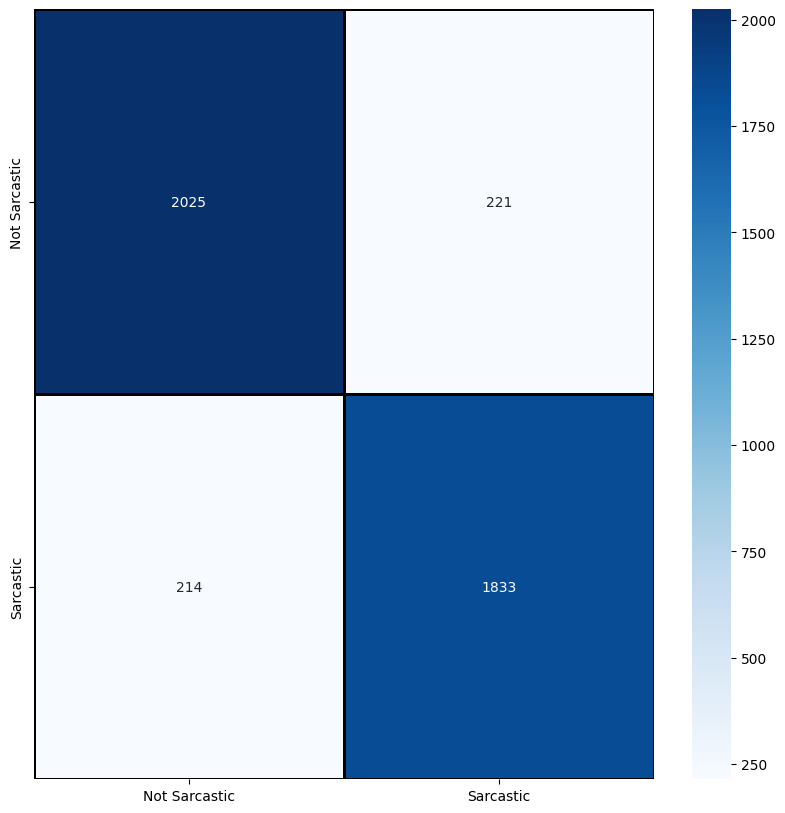

In [31]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])